In [9]:
import numpy as np
from matplotlib import pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
    file_name: Route of file containing the modified Jester dataset.
    context_dim: Context dimension (i.e. vector with some ratings from a user).
    num_actions: Number of actions (number of joke ratings to predict).
    num_contexts: Number of contexts to sample.
    shuffle_rows: If True, rows from original dataset are shuffled.
    shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
    dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
    opt_vals: Vector of deterministic optimal (reward, action) for each context.
    """
    np.random.seed(0)
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    return dataset, opt_rewards, opt_actions

In [15]:
def initiate_As(action_space, num_features):
    As = []
    for i in range(action_space):
        As.append(np.eye(num_features))
    return As

def initiate_bs(action_space, num_features):
    bs = []
    for i in range(action_space):
        bs.append(np.zeros(num_features))
    return bs

def inverse(matrix):
    return np.linalg.inv(matrix)

In [16]:
class UCB():
    
    def __init__(self):
        self.alpha = None
        self.As = None
        self.bs = None
        self.action_space = None
        self.num_features = None
    
    def train(self,alpha,action_space,num_features, data, cycle):
        As = initiate_As(action_space,num_features)
        bs = initiate_bs(action_space,num_features)
        rewards = []
        actions = []

        for n in range(cycle):
            for i in range(data.shape[0]):
                context = data[i,:num_features]
                payoffs = []
                for j in range(action_space):
                    theta = np.matmul(inverse(As[j]),bs[j])
                    payoff_current_arm = np.matmul(context,theta) + alpha * np.sqrt(np.matmul(np.matmul(context,inverse(As[j])),context))
                    payoffs.append(payoff_current_arm)

                action = np.argmax(payoffs)
                reward = data[i,num_features+action]
                rewards.append(reward)
                actions.append(action)
                As[action] += np.matmul(context.reshape(num_features,1),context.reshape(1,num_features))
                bs[action] += reward * context

        rewards = np.array(rewards)
        actions = np.array(actions)
        
        self.alpha = alpha
        self.action_space = action_space
        self.num_features = num_features
        self.As = As
        self.bs = bs
        
        return rewards, actions

    def test(self,data):
        rewards = []
        actions = []
        
        for i in range(data.shape[0]):
            context = data[i,:self.num_features]
            payoffs = []
            for j in range(self.action_space):
                theta = np.matmul(inverse(As[j]),bs[j])
                payoff_current_arm = np.matmul(context,theta) 
                payoffs.append(payoff_current_arm)

            action = np.argmax(payoffs)
            reward = data[i,self.num_features+action]
            rewards.append(reward)
            actions.append(action)
            
        return rewards, actions
    

# Training

In [10]:
import os
cd = os.getcwd()

In [13]:
jesterfile = cd + '/jester_data_40jokes_19181users.npy'
data,best_rewards,best_actions = sample_jester_data(jesterfile)

In [17]:
# Training alpha search
action_space = 8
num_features = 32
cycle = 2 # how many times to use one row of training data
training_size = 18000

alpha_list = [0.01,0.1,1,100]
grid_regret = []
grid_right_action_percentage = []
UCB_models = []

for alpha in alpha_list:
    model = UCB()
    rewards,actions = model.train(alpha,action_space,num_features,data[:training_size,:],cycle)
    UCB_models.append(model)

    regret = (np.cumsum(np.tile(best_rewards[:training_size],cycle) - rewards))**3
    right_action = 100*np.cumsum(np.tile(best_actions[:training_size],cycle) == actions)/(np.array(range(len(actions)))+1)
    grid_regret.append(regret)
    grid_right_action_percentage.append(right_action)
    print('alpha %.2f has finished' % alpha)

alpha 0.01 has finished
alpha 0.10 has finished
alpha 1.00 has finished
alpha 100.00 has finished


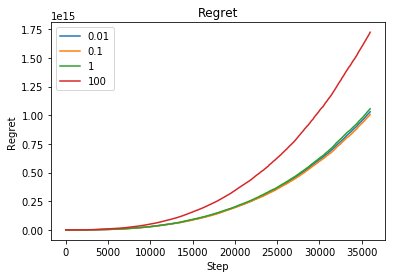

In [18]:
# regret plot
for i,regret in enumerate(grid_regret):
    plt.plot(regret,label=str(alpha_list[i]))
plt.ylabel('Regret')
plt.xlabel('Step')
plt.title('Regret')
plt.legend()
plt.show()

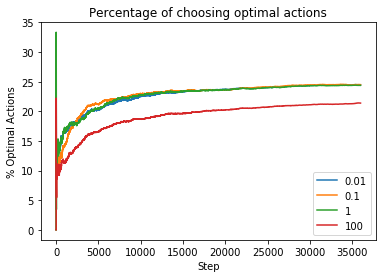

In [19]:
# right action percentage plot
for i,right_action in enumerate(grid_right_action_percentage):
    plt.plot(right_action,label=str(alpha_list[i]))
plt.ylabel('% Optimal Actions')
plt.xlabel('Step')
plt.title('Percentage of choosing optimal actions')
plt.legend()
plt.show()

# Test

In [22]:
# best model: Regret.min is alpha = 0.1 (The 2nd model)
model = UCB_models[1]
As = model.As
bs = model.bs
rewards, actions = model.test(data[training_size:,:])

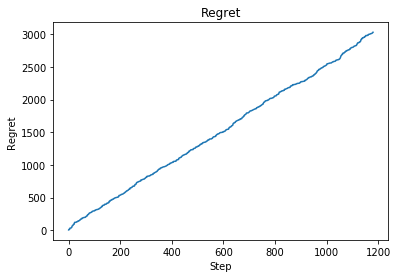

In [23]:
regret = np.cumsum(best_rewards[18000:] - rewards)
plt.plot(regret,label=str(alpha_list[i]))
plt.ylabel('Regret')
plt.xlabel('Step')
plt.title('Regret')
plt.show()

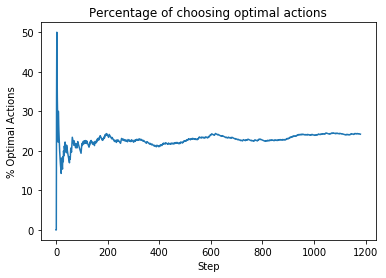

In [24]:
right_action = 100*np.cumsum(best_actions[18000:] == actions)/(np.array(range(len(actions)))+1)
plt.plot(right_action,label=str(alpha_list[i]))
plt.ylabel('% Optimal Actions')
plt.xlabel('Step')
plt.title('Percentage of choosing optimal actions')
plt.show()